<center><h1>Facial Expression Recognition Challenge</h1></center>
<br>
<center>Follow-up Research for Kaggle competition in 2013.</center>

 <center> <h5>서윤지, 부영건, 박지용, 최영록</h5> </center>

<img src="./image/front_page.png" alt="Drawing" style="width: 300px;"/>

# Dataset Introduction


 
* 48x48 pixel grayscale 얼굴 이미지
* 각 샘플은 7개 클래스 중 1개로 라벨링


|   0   |    1    |    2    |   3   |  4  |     5    |    6    |
|:-----:|:-------:|:-------:|:-----:|:---:|:--------:|:-------:|
| Angry | Disgust | Fear    | Happy | Sad | Surprise | Neutral |

* 데이터 셋 구성
> ** Training:** 28,709 samples  
> ** Public-test:** 3,589 samples (Public Leaderboard Benchmark)  
> ** Private-test:** 3,589 samples  
* Data Link: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
> provied by Pierre-Luc Carrier & Aron Courville

In [4]:
df = pd.read_csv('../../../dataset/face/fer2013.csv')
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


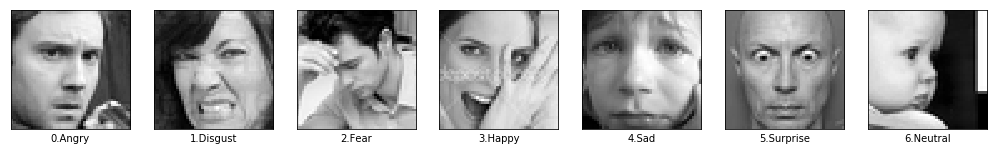

In [78]:
print_img(row=1, col=7, img_target=X_train, idx_target=Y_train, idx=[0, 388, 200, 97, 6, 15, 12])

> 얼굴 각도 및 사진에서 차지하는 얼굴 면적이 상이함  
> 워터마크 혹은 손으로 얼굴 일부분이 가려져 있는 샘플 존재

# 프로젝트 목표

* Neural Network 구조를 적용하여 Leaderboard 최고 점수를 상회하는 성능 Classifier 제작
* 다양한 문제 해결전략 시도를 통해 이미지 전처리/ Deep Learning 활용 테크닉 고도화

<img src="./image/Leaderboard.png" alt="Drawing" style="width: 600px;"/>

<br>
<br>
# 사용 패키지 소개

Keras 패키지를 통한 Convolutional Neural Network Modeling

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


<br>
<br>
# Preprocessing

* ### Dataset 구성

In [8]:
train = df[df.Usage == 'Training']
test = df[df.Usage == 'PrivateTest']
val = df[df.Usage == 'PublicTest']

<br>
* ### Build X sets
<br>
Gray scale 이미지 데이터를 CNN 모델에 집어 넣기 위해 *(데이터 수, 48, 48, 1)* 로 변환

In [9]:
def build_X(data):
    res = np.zeros((len(data), 48, 48, 1)).astype('float32')

    for i in range(len(data)):
        pixl = data.iloc[i,:].pixels.split(' ')
        pixels = np.array(pixl).astype('float32') / 255.
        pixels = pixels.reshape(48, 48, 1)
        res[i] = pixels
    
    return res

In [10]:
X_train = build_X(train)
X_test = build_X(test)
X_val = build_X(val)

In [11]:
X_train.shape

(28709, 48, 48, 1)

* ### Build Y sets
<br>
One-Hot Enconding  
> (0=Angry  |  1=Disgust  |  2=Fear  |  3=Happy  |  4=Sad  |  5=Surprise  |  6=Neutral)

In [12]:
# One Hot Encoding 7 categories
Y_train = np_utils.to_categorical(train.emotion.values, 7)
Y_test = np_utils.to_categorical(test.emotion.values, 7)
Y_val = np_utils.to_categorical(val.emotion.values, 7)

In [13]:
Y_train[:3]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]])

* ### Not Face Samples
<br>
Microsoft Azure의 Face Recognition 활용(https://github.com/Microsoft/FERPlus)  
Training Set에서 사람얼굴 표정으로 볼 수 없는 샘플 77개 육안으로 확인 후 최종 제거

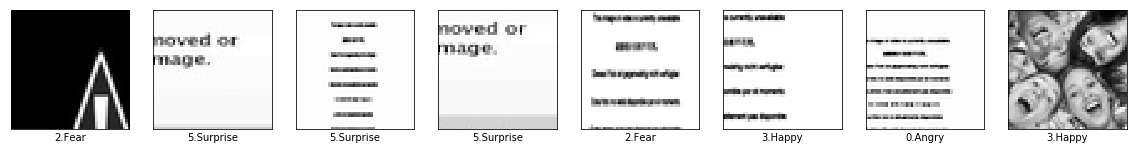

In [51]:
print_img(row=1, col=8, img_target=X_train, idx_target=Y_train, idx=[59, 2059, 2809, 3262, 3931,4275, 5439, 5509])

In [54]:
train_not_face = [59, 2059, 2809, 3262, 3931,4275, 5439, 5509, 5722, 5881, 6102, 6458, 6699, 7172,
 7496, 7527, 7629, 8030, 8737, 8856, 9026, 9500, 9673, 9679, 9693, 9797, 10023,
 10423, 10657, 11244, 11286, 11295, 11846, 12289, 12352, 13011, 13148, 13402, 13697,
 13839, 13988, 14148, 14279, 15144, 15553, 15838, 15894, 16024, 16540, 17081, 17620,
 18012, 18337, 19238, 19422, 19632, 20222, 20712, 20817, 21817, 22198,
 22407, 22927, 23596, 23894, 24053, 24441, 14593, 24891, 25219, 25603, 25909, 26383,
 26860, 26897, 28601, 19447]

In [56]:
train1 = train.drop(train_not_face, axis=0)
print('train: {}'.format(len(train)))
print('train1: {}'.format(len(train1)))

train: 28709
train1: 28632


In [57]:
X_train1 = build_X(train1)
Y_train1 = np_utils.to_categorical(train1.emotion.values, 7)

* ### Imbalanced Training Samples

트레이닝 샘플의 개수 불균형 문제

In [60]:
train1.groupby(['emotion'])['Usage'].count()

,pixels,Usage
emotion,,
0,3980,3980
1,435,435
2,4090,4090
3,7196,7196
4,4818,4818
5,3161,3161
6,4952,4952


<br>
* ### Image Augmentation
Link: https://keras.io/preprocessing/image/

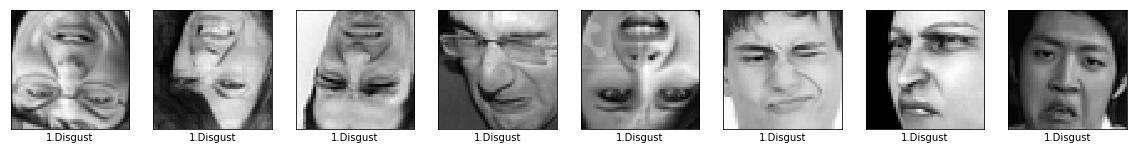

In [66]:
check_generator(X1, Y1, ImageDataGenerator(vertical_flip=True))

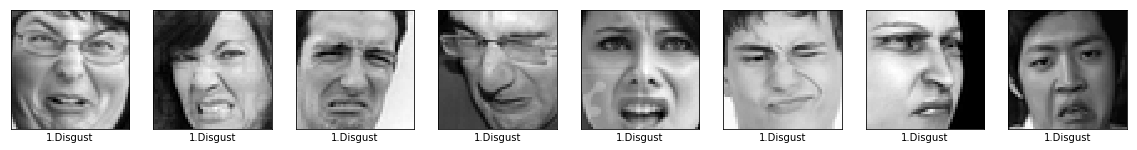

In [67]:
check_generator(X1, Y1, ImageDataGenerator(horizontal_flip=True))

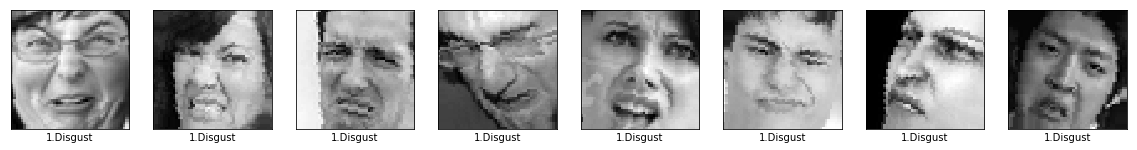

In [68]:
check_generator(X1, Y1, ImageDataGenerator(rotation_range=20))

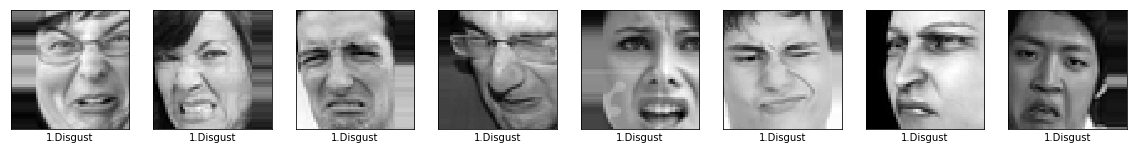

In [69]:
check_generator(X1, Y1, ImageDataGenerator(width_shift_range=0.2))

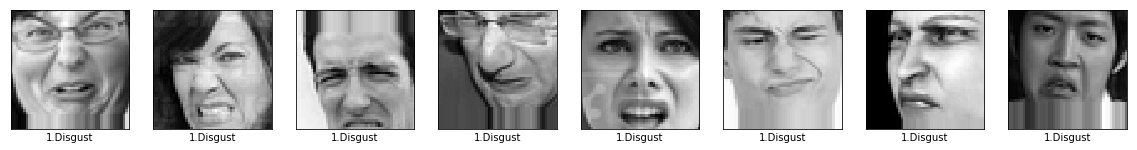

In [70]:
check_generator(X1, Y1, ImageDataGenerator(height_shift_range=0.2))

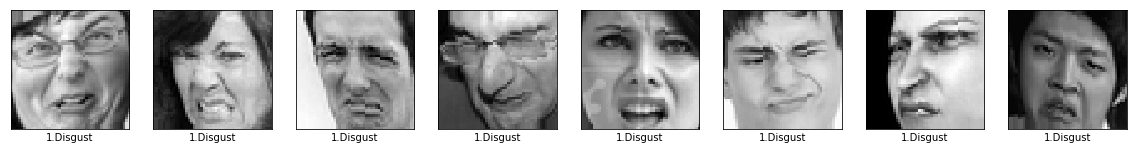

In [71]:
check_generator(X1, Y1, ImageDataGenerator(shear_range=0.2))

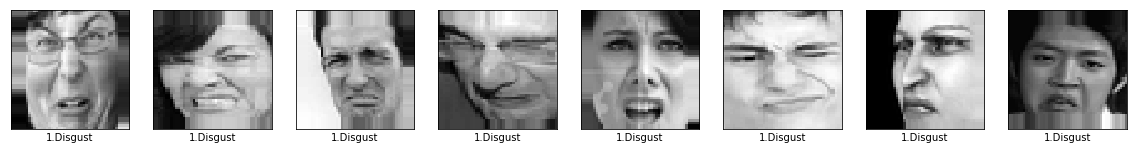

In [72]:
check_generator(X1, Y1, ImageDataGenerator(zoom_range=[0.7, 1.3]))

> 카테고리1(Disgust)는 타 카테고리 대비 상대적 비율 및 트레이닝 할만한 절대적 샘플 수 부족  
> keras.preprocessing.image.ImageDataGenerator 함수를 활용하여 Training Dataset 2610개 추가   ***(435 -> 3045)***

In [73]:
t1 = train1[train1.emotion == 1]

In [74]:
X1 = build_X(t1)
Y1 = np_utils.to_categorical(t1.emotion.values, 7)

In [75]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=[0.9, 1.1]
    )
datagen.fit(X1)

In [22]:
X = X1.copy()
Y = Y1.copy()

for i in range(6):
    for X_batch, Y_batch in datagen.flow(X1, Y1, batch_size=len(X1), shuffle=True):
        break
    
    X = np.vstack((X, X_batch))
    Y = np.vstack((Y, Y_batch))

In [26]:
train2 = train1[train1.emotion != 1]
X_train2 = build_X(train2)
Y_train2 = np_utils.to_categorical(train2.emotion.values, 7)

In [27]:
# Merge augmented training set of the category1(Disgust) to original Data set
X_train2 = np.vstack((X_train2, X))
Y_train2 = np.vstack((Y_train2, Y))

In [38]:
dfX = pd.DataFrame(X_train2.reshape(31242, 2304))
dfY = pd.DataFrame(Y_train2)

In [45]:
print('Category 0: {}'.format(len(dfY[dfY[0] == 1])))
print('Category 1: {}'.format(len(dfY[dfY[1] == 1])))
print('Category 2: {}'.format(len(dfY[dfY[2] == 1])))
print('Category 3: {}'.format(len(dfY[dfY[3] == 1])))
print('Category 4: {}'.format(len(dfY[dfY[4] == 1])))
print('Category 5: {}'.format(len(dfY[dfY[5] == 1])))
print('Category 6: {}'.format(len(dfY[dfY[6] == 1])))

Category 0: 3980
Category 1: 3045
Category 2: 4090
Category 3: 7196
Category 4: 4818
Category 5: 3161
Category 6: 4952


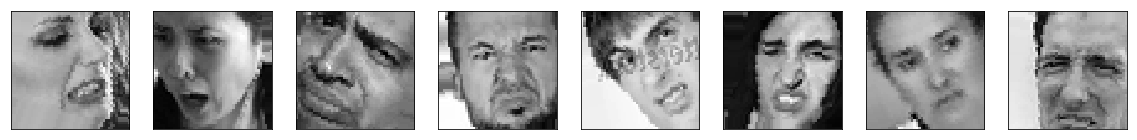

In [30]:
print_img(row=1, col=8, target=X_train2, idx=[30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007])

In [190]:
%%time
np.savetxt('../dataset/face/X_train.txt', X_train2.reshape((31242, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_train.txt', Y_train2, delimiter=',')
np.savetxt('../dataset/face/X_test.txt', X_test.reshape((3589, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_test.txt', Y_test, delimiter=',')

CPU times: user 1min 10s, sys: 1.52 s, total: 1min 11s
Wall time: 1min 20s


<br>
* ### 오버샘플링을 통한 Imbalanced Training Set 문제 해결

카테고리1(Disgust) 샘플 추가 후 모든 카테고리 Sample 개수를 최대 샘플 수를 가진 카테고리3(Happy) 와 동일하게 7196개로 Augmentation  
카테고리3(Happy) 샘플 수가 다른 카테고리 샘플보다 약 2배 가량 많은 Dataset Imbalance 해소

In [62]:
X0 = X_train2[dfY[dfY[0] == 1].index.values]
X1 = X_train2[dfY[dfY[1] == 1].index.values]
X2 = X_train2[dfY[dfY[2] == 1].index.values]
X3 = X_train2[dfY[dfY[3] == 1].index.values]
X4 = X_train2[dfY[dfY[4] == 1].index.values]
X5 = X_train2[dfY[dfY[5] == 1].index.values]
X6 = X_train2[dfY[dfY[6] == 1].index.values]

In [63]:
Y0 = Y_train2[dfY[dfY[0] == 1].index.values]
Y1 = Y_train2[dfY[dfY[1] == 1].index.values]
Y2 = Y_train2[dfY[dfY[2] == 1].index.values]
Y3 = Y_train2[dfY[dfY[3] == 1].index.values]
Y4 = Y_train2[dfY[dfY[4] == 1].index.values]
Y5 = Y_train2[dfY[dfY[5] == 1].index.values]
Y6 = Y_train2[dfY[dfY[6] == 1].index.values]

In [106]:
X0.shape

(3980, 48, 48, 1)

In [100]:
def over_sampling(X0, Y0):    
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        shear_range=0.1,
        height_shift_range=0.1,
        width_shift_range=0.1,
        zoom_range=[0.9, 1.1]
        )
    datagen.fit(X0)

    X = X0.copy()
    Y = Y0.copy()

    while(1):
        for X_batch, Y_batch in datagen2.flow(X0, Y0, batch_size=(len(X3) - len(X)), shuffle=True):
            break

        X = np.vstack((X, X_batch))
        Y = np.vstack((Y, Y_batch))
    
        if (len(X) == 7196):
            break
    
    return (X, Y)

In [101]:
X00, Y00 = over_sampling(X0, Y0)
X11, Y11 = over_sampling(X1, Y1)
X22, Y22 = over_sampling(X2, Y2)
X33, Y33 = over_sampling(X3, Y3)
X44, Y44 = over_sampling(X4, Y4)
X55, Y55 = over_sampling(X5, Y5)
X66, Y66 = over_sampling(X6, Y6)

In [102]:
print('Category 0: {}'.format(len(X00)))
print('Category 1: {}'.format(len(X11)))
print('Category 2: {}'.format(len(X22)))
print('Category 3: {}'.format(len(X33)))
print('Category 4: {}'.format(len(X44)))
print('Category 5: {}'.format(len(X55)))
print('Category 6: {}'.format(len(X66)))

Category 0: 7196
Category 1: 7196
Category 2: 7196
Category 3: 7196
Category 4: 7196
Category 5: 7196
Category 6: 7196


In [112]:
X_train3 = np.vstack((X00, X11, X22, X33, X44, X55, X66))
Y_train3 = np.vstack((Y00, Y11, Y22, Y33, Y44, Y55, Y66))

In [113]:
X_train3.shape

(50372, 48, 48, 1)

In [114]:
Y_train3.shape

(50372, 7)

In [ ]:
%%time
np.savetxt('../dataset/face/X_train2.txt', X_train3.reshape((50372, 2304)), delimiter=',')
np.savetxt('../dataset/face/Y_train2.txt', Y_train3, delimiter=',')

<br>
# CNN 모델링

In [21]:
model0 = keras.models.load_model("../../../models/face_model1.hdf5")
model1 = keras.models.load_model("../../../models/face_model2.hdf5")
model2 = keras.models.load_model("../../../models/face_model4.hdf5")

In [ ]:
np.random.seed(10)

model0 = Sequential()

model0.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1), padding='same', kernel_regularizer=l2(0.001)))
model0.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model0.add(MaxPooling2D())
model0.add(Dropout(0.5))

model0.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model0.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model0.add(MaxPooling2D())
model0.add(Dropout(0.5))

model0.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model0.add(Conv2D(256, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model0.add(MaxPooling2D())
model0.add(Dropout(0.5))

model0.add(Flatten())
model0.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model0.add(Dropout(0.5))
model0.add(Dense(7, activation='softmax'))

opt = optimizers.Adadelta()
model0.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
__________

#### Fit w/ Original Training Set (n=28,632)

In [23]:
model0.evaluate(X_val, Y_val)

3589/3589 [==============================] - 3s     


[1.7511817235805822, 0.63833937030643695]

<img src="./image/model1_hist.png" alt="Drawing" style="width: 600px;"/>

#### Fit w/ Augmented Training Set 1 (n=31,242)
- Category1 (435 -> 3045)

In [24]:
model1.evaluate(X_val, Y_val)

3552/3589 [============================>.] - ETA: 0s

[1.7327172259960244, 0.65059905269412355]

<img src="./image/model2_hist.png" alt="Drawing" style="width: 600px;"/>

#### Fit w/ Augmented Training Set 2 (n=50,372)
- All Categories to 7196

In [56]:
model2.evaluate(X_val, Y_val)

3584/3589 [============================>.] - ETA: 0s

[1.6020037849888094, 0.64641961552499561]

<img src="./image/model5_hist.png" alt="Drawing" style="width: 600px;"/>

<br>


|   0   |    1    |    2    |   3   |  4  |     5    |    6    |
|:-----:|:-------:|:-------:|:-----:|:---:|:--------:|:-------:|
| Angry | Disgust | Fear    | Happy | Sad | Surprise | Neutral |

<div style="float:left; width: 33%;">
<p style="font-size:15px; text-align:center;">Fit w/ Original(n=28,632)¶</p>
<img src="./image/model1_a.png" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 33%;">
<p style="font-size:15px; text-align:center;">Fit w/ Augmented 1 (n=31,242)</p>
<img src="./image/model2_a.png" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 33%;" align="center">
<p style="font-size:15px; text-align:center;">Fit w/ Augmented 2 (n=50,372)</p>
<img src="./image/model4_a.png" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 33%;">
<p style="font-size:15px; text-align:center;">Fit w/ Original(n=28,632)¶</p>
<img src="./image/model1_b.png" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 33%;">
<p style="font-size:15px; text-align:center;">Fit w/ Augmented 1 (n=31,242)</p>
<img src="./image/model2_b.png" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 33%;">
<p style="font-size:15px; text-align:center;">Fit w/ Augmented 2 (n=50,372)</p>
<img src="./image/model4_b.png" alt="Drawing" style="width: 300px;"/>
</div>

<img src="./image/Kirouac.png" alt="Drawing" style="width: 600px;"/>

<p style="font-size:12px; text-align:center;">
Accuracy of the judgment of facial expression of emotions as a function of sex and level of education, 1985, Gilles Kirouac, François Y Doré
</p>

<br>
# 이중 모델 파이프라인

1. Recall Rate이 높은 Category3: **Happy$\rightarrow$0** Category5: **Surprise$\rightarrow$1** 를 우선 선별  
   - 나머지 카테고리는 **Others$\rightarrow$2** 로 Classification
2. Others(2)에 대해서 다시 한 번 7개 전체 카테고리 Classification

<img src="./image/russell.png" alt="Drawing" style="width: 400px;"/>

<p style="font-size:12px; text-align:center;">Russell's circumplex model of affect, 1985, Russell</p>

In [36]:
def pipeline(X, m1, m2):

    model1 = keras.models.load_model("../../../models/" + m1) # 1st
    model2 = keras.models.load_model("../../../models/" + m2) # 2nd

    Y_pred = model2.predict_classes(X)
    proba_pred = model2.predict(X)
    
    dfP = pd.DataFrame(Y_pred, columns=['pred0'])
    dfP['pred1'] = Y_pred
    dfP['0'] = proba_pred[:, 0]; dfP['1'] = proba_pred[:, 1]; dfP['2'] = proba_pred[:, 2]; dfP['3'] = proba_pred[:, 3];
    dfP['4'] = proba_pred[:, 4]; dfP['5'] = proba_pred[:, 5]; dfP['6'] = proba_pred[:, 6]

    r1 = model1.predict_classes(X)
    pred1 = np.zeros(len(r1), dtype=int)
    pred1[r1 == 0] = 3
    pred1[r1 == 1] = 5
    dfP['pred1'] = pred1

    dfP2 = dfP.loc[np.where(r1 == 2)[0]]
    pred2 = model2.predict_classes(X[np.where(r1 == 2)[0]])
    dfP['pred1'][dfP2.index] = pred2

    return dfP

<br>
* ### 파이프라인 적용 결과

#### Fit w/ Original Training Set (n=28,632)

In [43]:
Res0 = pipeline(X_val, 'face_M11.hdf5', 'face_model1.hdf5')

2240/2264 [============================>.] - ETA: 0s

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
print_ppscore(Res0, val.emotion.values)

acc0: 0.638339370298
acc1: 0.644747840624


<br>
#### Fit w/ Augmented Training Set 1 (n=31,242)
- Category1 (435 -> 3045)

In [51]:
Res1 = pipeline(X_val, 'face_M11.hdf5', 'face_model2.hdf5')

2240/2264 [============================>.] - ETA: 0s

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [52]:
print_ppscore(Res1, val.emotion.values)

acc0: 0.650599052661
acc1: 0.652270827529


<br>
#### Fit w/ Augmented Training Set 1 (n=50,372)
- All Categories to 7196

In [41]:
Res2 = pipeline(X_val, 'face_M11.hdf5', 'face_model4.hdf5')

2240/2264 [============================>.] - ETA: 0s

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
print_ppscore(Res2, val.emotion.values)

acc0: 0.646419615492
acc1: 0.654221231541


<br>
# GoogLeNet [1]

* 딥러닝은 망이 깊고(depth) 레이어가 넓을 수록(wide) 성능이 좋다.
* 현실에서는 과최적화나 그레디언트 소멸문제가 발생
* 망내 연결을 줄이면서 행렬연산에서는 dense하게 연산되는 모델 구성

<img src="../yj/f02.png" alt="Drawing" style="width: 1000px;"/>

* ### Inception module

중간에 추가된 1$\times$1 convolution layer에 의해 계산상의 병목현상(bottleneck)을 줄이고 연산 페널티를 크게 늘리지 않으면서 네트워크의 깊이와 넓이를 확장해준다.

<img src="../yj/inception_1x1.png" alt="Drawing" style="width: 800px;"/>

<div style="float:left; width: 50%;">
<img src="./image/full_padding_no_strides_transposed_small.gif" alt="Drawing" style="width: 300px;"/>
</div>

<div style="float:left; width: 50%;">
<img src="./image/full_padding_no_strides_transposed.gif" alt="Drawing" style="width: 300px;"/>
</div>

In [ ]:
# Inception (dimension reductions) -- b

tower_0 = Conv2D(160, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)

tower_1 = Conv2D(112, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_1 = Conv2D(224, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_1)

tower_2 = Conv2D(24, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(tower_3)

x = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)

GoogLeNet에서 input data는 224$\times$224 이미지이다. fer2013의 경우 48 $\times$ 48 이미지가 input data이기 때문에 적절하게 layer를 줄여야한다.[6]

<img src="../yj/glns.PNG" alt="Drawing" style="width: 1000px;"/>

In [ ]:
from time import time
from trial_record import savefigure, trial_record

path = 'C:/Anaconda2/bin/dataset'
df_x = pd.read_csv('%s/X_train.txt'%path, header=None)
df_y = pd.read_csv('%s/Y_train.txt'%path, header=None)
df_xt = pd.read_csv('%s/X_test.txt'%path, header=None)
df_yt = pd.read_csv('%s/Y_test.txt'%path, header=None)

X_train = np.array(df_x).astype('float32')
X_train = X_train.reshape(31242, 48, 48, 1)
Y_train = np.array(df_y)
X_test = np.array(df_xt).astype('float32')
X_test = X_test.reshape(3589, 48, 48, 1)
Y_test = np.array(df_yt)

path2 = 'C:/Anaconda2/bin/fer2013/fer2013'
df = pd.read_csv('%s/all.csv'%path2)
df.drop('Unnamed: 0', axis=1, inplace=True)

df_pub = df[df.Usage == 'PublicTest']
X_pub = np.array(df_pub.iloc[:, 2:]).astype('float32') / 255.
X_pub = X_pub.reshape(3589, 48, 48, 1)
y_pub = np.array(df_pub.iloc[:, 0])
Y_pub = to_categorical(y_pub, 7)

input_img = Input(shape=(48, 48, 1))
reg = [0.005, 0.]
x = Conv2D(64, (7, 7), padding='same', strides=2, activation='relu', kernel_regularizer=l2(reg[1]))(input_img)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
x = Conv2D(192, (3, 3), padding='same', strides=1, activation='relu', kernel_regularizer=l2(reg[1]))(x)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
# Inception (dimension reductions) -- b
tower_0 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)

tower_1 = Conv2D(96, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_1 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_2 = Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(tower_3)

x = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)
# inception 끝
# Inception (dimension reductions) -- b
tower_0 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)

tower_1 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_1 = Conv2D(192, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_1)

tower_2 = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_2 = Conv2D(96, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(tower_3)

x = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)
# inception 끝
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# Inception (dimension reductions) -- b
tower_0 = Conv2D(192, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)

tower_1 = Conv2D(96, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_1 = Conv2D(208, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(x)
tower_2 = Conv2D(48, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(reg[0]))(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(reg[1]))(tower_3)

x = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)
# inception 끝
x = AveragePooling2D((3, 3), strides=1)(x)

output = Flatten()(x)
output = Dense(4096, activation='relu')(output)
predictions = Dense(7, activation='softmax')(output)
model = Model(inputs=input_img, outputs=predictions)
print(model.summary() )
opt = optimizers.Adadelta()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
ct = time()
hist = model.fit(X_train, Y_train, epochs=80, batch_size=100, validation_data=(X_test, Y_test), verbose=2)
t = time() - ct

print(model.evaluate(X_pub, Y_pub, verbose=2))
model.save('%s/GLN_%s.hdf5'%(path2, 2))

<br>
<div>
    <p style="font-size:15px; text-align:center;"><b>Performance Table</b></p>
</div>

|Model     |acc      |loss     |
|:---------|:--------|:--------|
|GLN_mini  |0.6016   |3.5475   |
|GLN       |0.5829   |2.8499   |

<p style="font-size:12px; text-align:center;">Fit w/ Augmented Training Set 1 (n=31,242)</p>

<br>
# Other CNN Strunctures


|Method | FD | LM | Registration | Illumionation | Accuracy(Public) | Architecture | Depth | Parameters | AD | AF | + Train | + Test | Ensemble |
|-------|----|----|-------------|----------------|---------------------------|----|----|-------------|:----:|:----:|:----:|--------|---------|
|Method 1| no| no|no | normalize | 71.2%|   CPCPFF| 4 | 12.0 m |  no | no | S, M | -| average |
|Method 2| several | no | no | histeq, LPF |72%|   PCCPCCPCFFF | 8 | 6.2 m | no | no | A, M | A| weighted |
|Method 3 | no |ref* | rigid (LM) | several | 73.5% |   CPCPCPFF | 5 | 2.4 m |  no | yes | T, M, REG | ten-crop, REG| average |
|Method 4| several | ref* |rigid (LM) | several |72.5%|   CPCPCPFF | 5 | 4.8 m |  no | no | T, M | - | hierarchy |
|Method 5| no | ref* | affine (LM) | no | 66.5% |  CPCPIIPIPFFF | 11 | 7.3 m | yes | no | ten-crop |-| -|
|Method 6| no | ref* | indirect | no | 75% |  CPNCPNCPCFF | 6 | 21.3 m | yes | yes | - |- |- |

#### 약자 설명

|Preprocessing|Structure|Differences1| Differences2|
|:---|:---|:---|:---|
|FD: Facial Detection|C: Convolutional|AD: Additional Training Data|S: Similarity Transformation|
 |LM: Facial Landmark Extraction|P: Pooling| AF: Additional Features |A: Affine Transformation|
 |HISTEQ: Histogram Equalization|N: Response-Normalization| +: Data augmentation |T:Translation|
 |LPF: Linear Plane Fitting|I: Inception|  REG: Face Registration |M: Horizontal Mirroring|
 ||F: Fully connected layers| 

<br>
<div>
    <p style="font-size:15px; text-align:center;"><b>Performance Table</b></p>
</div>

|Model     |acc      |loss     |
|:---------|:--------|:--------|
|Method 1  |0.5890   |2.5409   |
|Method 2  |0.4238   |4.9818   |
|Method 3  |0.5893   |2.7768   |

<p style="font-size:12px; text-align:center;">Fit w/ Augmented Training Set 2 (n=50,372)</p>

# Conclusion

* ** Hightest Accuracy:** 0.6542
* 5th rank on the FER2013 competition public leaderboard

|Accuracy(Public)	|Architecture     |Depth     |Parameters|+ Train|Pipeline|
|:---------|:--------|:--------|:----|:----|:----|
|0.6542    |CCPDCCPDCCPDFFDF |6 |7.9m|S,A,T,M|2depth|

<p style="font-size:12px; text-align:center;">Fit w/ Augmented Training Set 2 (n=50,372) + Pipeline</p>

<p style="font-size:12px; text-align:center;">D: Dropout()</p>

In [55]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
__________

<br>
* ### Human Accuracy on FER2013: 65$\pm$5 %  


Challenges in Representation Learning: A report on three machine learning contests [10]

<br>

* ### Comments and Future works

* 데이터 중 얼굴이 아닌 데이터 여전히 존재
    * 얼굴 인지(Face registration)를 연구하여 성능향상
* Image rotation, shearing, resizing 기술 적용
* Training Dataset Imbalance 문제 해결 전략 다양하게 시도(데이터셋 추가, Under Sampling)
* 다양한 데이터셋 시도
* 얼굴 특징 인지(Facial Landmark detection)를 연구하여 성능향상(진행중)
    * IntraFace 지원종료로 다른 방법 시도(dataset에서 직접 training, 다른 패키지 시도)

<br>
## References

[1] Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich, "Going Deeper with Convolutions", https://arxiv.org/abs/1409.4842  

Method 1: [2] Y. Tang, "Deep Learning using Linear Support Vector Machines", https://arxiv.org/abs/1306.0239  

Method 2: [3] Z. Yu and C. Zhang, “Image based static facial expression recognition with multiple deep network learning”, in ACM International Conference on Multimodal Interaction (MMI), http://dl.acm.org/citation.cfm?id=2830595  

Method 3: [4] B.-K. Kim, S.-Y. Dong, J. Roh, G. Kim, and S.-Y. Lee, “Fusing Aligned and Non-Aligned Face Information for Automatic Affect Recognition in the Wild: A Deep Learning Approach", http://www.cv-foundation.org/openaccess/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf  

Method 4: [5] B.-K. Kim, J. Roh, S.-Y. Dong, and S.-Y. Lee, "Hierarchical committee of deep convolutional neural networks for robust facial expression recognition", https://www.springerprofessional.de/hierarchical-committee-of-deep-convolutional-neural-networks-for/11809924  

Method 5: [6] A. Mollahosseini, D. Chan, and M. H. Mahoor, “Going Deeper in Facial Expression Recognition using Deep Neural Networks", https://arxiv.org/abs/1511.04110  

Method 6: [7] Z. Zhang, P. Luo, C.-C. Loy, and X. Tang, “Learning Social Relation Traits from Face Images", http://mmlab.ie.cuhk.edu.hk/projects/socialrelation/support/ICCV15.pdf  

ref*: [8] X. Xiong and F. Torre, “Supervised descent method and its applications to face alignment", http://www.ri.cmu.edu/pub_files/2013/5/main.pdf  

[9] Christopher Pramerdorfer, Martin Kampel, "Facial Expression Recognition using Convolutional Neural Networks: State of the Art", https://pdfs.semanticscholar.org/4edc/7f27d4512b69be54abfc6b9876e5b00725ab.pdf  

[10] Ian J. Goodfellow, Dumitru Erhan, Pierre Luc Carrier, Aaron Courville, Mehdi Mirza, Ben Hamner, Will Cukierski, Yichuan Tang, David Thaler, Dong-Hyun Lee, Yingbo Zhou, Chetan Ramaiah, Fangxiang Feng, Ruifan Li, Xiaojie Wang, Dimitris Athanasakis, John Shawe-Taylor, Maxim Milakov, John Park, Radu Ionescu, Marius Popescu, Cristian Grozea, James Bergstra, Jingjing Xie, Lukasz Romaszko, Bing Xu, Zhang Chuang, Yoshua Bengio, Challenges in Representation Learning: A report on three machine learning contests, https://arxiv.org/abs/1307.0414  

[11] "Challenges in Representation Learning: Facial Expression Recognition Challenge", https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data